In [49]:
import os
import pandas as pd
import numpy as np
import math
import time
import argparse
import torch
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch.nn import Module
from torch import optim
import tqdm
import shutil
from torch.utils.tensorboard import SummaryWriter
import datetime
from multiprocessing import cpu_count
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from matplotlib.pylab import mpl

In [11]:
%matplotlib qt

In [ ]:
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
mpl.rcParams['axes.unicode_minus'] = False  #显示负号

In [174]:
def classify_provider(features_path, label_path, n_splits, batch_size, num_workers, method='origin'):
    # Amp,RiseT,Dur,Eny,RMS,Counts
    with open(features_path, 'r') as f:
        feature = np.array([i.split(',')[6:-4] for i in f.readlines()[1:]])
    feature = feature.astype(np.float32)

    with open(label_path, 'r') as f:
        label = np.array([i.strip() for i in f.readlines()[1:]])
    label = label.astype(np.float32).reshape(-1, 1)
    label[np.where(label == 2)] = 0
    ext = np.zeros([feature.shape[0], 1]).astype(np.float32)
    ext[np.where(label == 0)[0].tolist()] = 1
    label = np.concatenate((label, ext), axis=1)

    df = pd.DataFrame(feature)
    df.columns = ['Amp', 'RiseT', 'Dur', 'Eny', 'RMS', 'Counts']
    df['Counts/Dur'] = df['Counts'] / df['Dur']
    df['RiseT/Dur'] = df['RiseT'] / df['Dur']
    df['Eny/Dur'] = df['Eny'] / df['Dur']
    df['Amp*RiseT'] = df['Amp'] * df['RiseT']

    if method == '10_select':
        feature = df.values
    elif method == '6_select':
        feature = df[['Eny', 'Amp*RiseT', 'Dur', 'RMS', 'Counts/Dur', 'RiseT/Dur']].values

    train_dfs = list()
    val_dfs = list()
    all_dfs = list()
    if n_splits != 1:
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=69)
        for train_df_index, val_df_index in skf.split(feature, label[:, 0]):
            train_dfs.append([feature[train_df_index], label[train_df_index, :]])
            val_dfs.append([feature[val_df_index], label[val_df_index, :]])
    else:
        df_temp = train_test_split(feature, label, test_size=0.2, stratify=label, random_state=69)
        train_dfs.append([df_temp[0], df_temp[2]])
        val_dfs.append([df_temp[1], df_temp[3]])
        all_dfs.append([np.concatenate((df_temp[0], df_temp[1]), axis=0),
                         np.concatenate((df_temp[2], df_temp[3]), axis=0)])
        # print(len(train_dfs), len(val_dfs), len(all_dfs))

    dataloaders = list()
    for df_index, (train_df, val_df, all_df) in enumerate(zip(train_dfs, val_dfs, all_dfs)):
        train_dataset = SteelClassDataset(train_df)
        val_dataset = SteelClassDataset(val_df)
        all_dataset = SteelClassDataset(all_df)
        train_dataloader = DataLoader(train_dataset,
                                      batch_size=batch_size,
                                      num_workers=num_workers,
                                      pin_memory=False,
                                      shuffle=True)
        val_dataloader = DataLoader(val_dataset,
                                    batch_size=batch_size,
                                    num_workers=num_workers,
                                    pin_memory=False,
                                    shuffle=False)
        all_dataloader = DataLoader(all_dataset,
                                     batch_size=batch_size,
                                     num_workers=num_workers,
                                     pin_memory=False,
                                     shuffle=False)
        dataloaders.append([train_dataloader, val_dataloader, all_dataloader])
    return feature, label, dataloaders


class SteelClassDataset(Dataset):
    def __init__(self, dataset):
        super(SteelClassDataset, self).__init__()
        self.feature = dataset[0]
        self.label = dataset[1]

    def __getitem__(self, idx):
        x = self.feature[idx]
        y = self.label[idx]
        return x, y

    def __len__(self):
        return len(self.label)

In [4]:
class Classify_model(Module):
    def __init__(self, layer, method='origin', training=True):
        super(Classify_model, self).__init__()
        if method in ['origin', '6_select']:
            self.linear1 = torch.nn.Linear(6, layer[0])
            self.linear2 = torch.nn.Linear(layer[0], layer[1])
            self.linear3 = torch.nn.Linear(layer[1], 2)
        elif method == '10_select':
            self.linear1 = torch.nn.Linear(10, layer[0])
            self.linear2 = torch.nn.Linear(layer[0], layer[1])
            self.linear3 = torch.nn.Linear(layer[1], layer[2])
            self.linear4 = torch.nn.Linear(layer[2], 2)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.training = training

    def forward(self, input, method):
        if method in ['origin', '6_select']:
            y = self.linear1(input)
            y = self.relu(y)
            y = self.linear2(y)
            y = self.relu(y)
            y = self.linear3(y)
        elif method == '10_select':
            y = self.linear1(input)
            y = self.sigmoid(y)
            y = F.dropout(y, 0.5, training=self.training)
            y = self.linear2(y)
            y = self.sigmoid(y)
            y = F.dropout(y, 0.5, training=self.training)
            y = self.linear3(y)
            y = self.sigmoid(y)
            y = F.dropout(y, 0.5, training=self.training)
            y = self.linear4(y)
        return y

In [5]:
class Solver():
    def __init__(self, model, method):
        self.model = model
        self.method = method

    def forward(self, x):
        outputs = self.model(x, self.method)
        return outputs

    def cal_loss(self, targets, predicts, criterion):
        return criterion(predicts, targets)

    def backword(self, optimizer, loss):
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    def save_checkpoint(self, save_path, state, is_best):
        # torch.save(state, save_path)
        if is_best:
            torch.save(state, save_path)
            print('Saving Best Model.')
            # save_best_path = save_path.replace('.pth', '_best.pth')
            # shutil.copyfile(save_path, save_best_path)

    def load_checkpoint(self, load_path):
        if os.path.isfile(load_path):
            checkpoint = torch.load(load_path, map_location='cpu')
            # self.model.module.load_state_dict(checkpoint['state_dict'])
            print('Successfully Loaded from %s' % (load_path))
            return self.model
        else:
            raise FileNotFoundError(
                "Can not find weight file in {}".format(load_path))

In [176]:
if __name__ == "__main__":
    method = 'origin'
    features_path = './pri_database.txt'
    label_path = './label.txt'
    weight_path = './checkpoints/origin/2020-11-16T14-26-21-16-classify/classify_fold0_origin_0.973121.pth'
    n_splits = 1
    batch_size = 16
    layer = [100, 80, 10]
    feature, _, dataloaders = classify_provider(
        features_path, label_path, n_splits, batch_size, 0, method)

    model = Classify_model(layer, method, training=False)
    model.eval()
    model.train(False)
    solver = Solver(model, method)
    checkpoint = torch.load(weight_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['state_dict'], False)
    tbar = tqdm.tqdm(dataloaders[0][2], ncols=80)
    res, res_sigmoid, res_01, Label = [], [], [], []
    with torch.no_grad():
        for i, (x, labels) in enumerate(tbar):
            labels_row = solver.forward(x)
            labels_predict = torch.sigmoid(labels_row)
            predict = (labels_predict > 0.5).float()
            res_01.append(predict.data.cpu().numpy())
            res_sigmoid.append(labels_predict.data.cpu().numpy())
            res.append(labels_row.data.cpu().numpy())
            Label.append(labels.data.cpu().numpy())
            correct.append(sum(predict+labels == 2).data.cpu().numpy())

100%|█████████████████████████████████████████| 41/41 [00:00<00:00, 1138.97it/s]


In [163]:
def metric(p, t):
    tp = ((p[:,1] + t[:,1]) == 2).sum(0)  # True positives
    tn = ((p[:,0] + t[:,0]) == 2).sum(0)  # True negatives
    total_pos = t[:, 1].sum(0)
    total_neg = t[:, 0].sum(0)
    fp = total_neg - tn    # 将负类错误预测为正类数
    fn = total_pos - tp     # 将正类错误预测为负类数
    # 各个类别预测正确的正样本、负样本数目
    class_neg_accuracy = tn / t[:, 0].sum(0)
    class_pos_accuracy = tp / t[:, 1].sum(0)
    
    return class_pos_accuracy, class_neg_accuracy, tp, total_pos, tn, total_neg, fp, fn

In [177]:
pre = np.concatenate([i for i in res_01])
label = np.concatenate([i for i in Label])
class_pos_accuracy, class_neg_accuracy, tp, total_pos, tn, total_neg, fp, fn = metric(pre, label)
print('{:.5f}, {:.5f}, {}/{:.0f}, {}/{:.0f}, {:.0f}, {:.0f}'.
      format(class_pos_accuracy, class_neg_accuracy, tp, total_pos, tn, total_neg, fp, fn))

0.92941, 0.98228, 237/255, 388/395, 7, 18


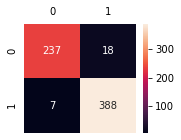

In [178]:
_, _, tp, _, tn, _, fp, fn = metric(pre, label)

cm = np.zeros([2, 2])
cm[0][0], cm[0][1], cm[1][0], cm[1][1] = tp, fn, fp, tn
f,ax=plt.subplots(figsize=(2.5, 2))
sns.heatmap(cm,annot=True,ax=ax, fmt='.20g') #画热力图
# ax.set_title('Confusion Matrix') #标题
# ax.set_xlabel('Predicted label') #x轴
# ax.set_ylabel('True label') #y轴

ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('left')
# ax.set_xticks(['Class 1', 'Class 2'])
# ax.set_yticks(['Class 1', 'Class 2'])
ax.tick_params(bottom=False,top=False,left=False,right=False)

## ROC curve

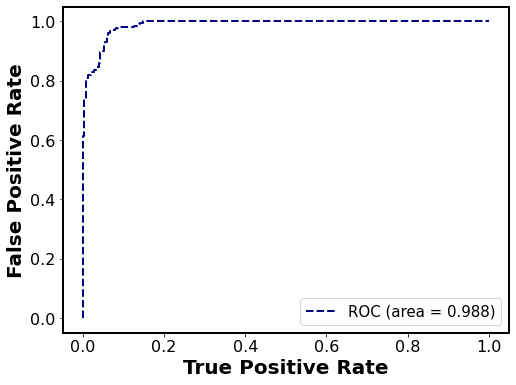

In [173]:
y_pre = np.concatenate([i for i in res_sigmoid])
fpr, tpr, thersholds = roc_curve(label[: ,0], y_pre[: ,0])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=[8, 6])
plt.plot(fpr, tpr, 'k--', color='navy', label='ROC (area = {0:.3f})'.format(roc_auc), lw=2)

ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

font_legend = {'family':'DejaVu Sans','weight':'normal','size':15}
font_label = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 20}
font_title = {'family': 'DejaVu Sans', 'weight': 'bold', 'size': 30}

# 设置坐标刻度值的大小以及刻度值的字体
plt.tick_params(labelsize=16)
labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_fontname('DejaVu Sans') for label in labels]

# plt.xlim(-5, 150)
# plt.xticks(range(0, 149, 29), labels=['1', '30', '60', '90', '120', '150'])
plt.ylabel('False Positive Rate', font_label)
plt.xlabel('True Positive Rate', font_label)
plt.legend(loc="lower right", prop=font_legend)

## Export ML

In [ ]:
def cal_ML(tmp, features_path, cls_1, cls_2):
    tmp_1, tmp_2 = sorted(tmp[cls_1]), sorted(tmp[cls_2])
    N1, N2 = len(tmp_1), len(tmp_2)
    ML_y1, ML_y2 = [], []
    Error_bar1, Error_bar2 = [] ,[]
    for j in range(N1):
        valid_x = sorted(tmp_1)[j:]
        E0 = valid_x[0]
        Sum = np.sum(np.log(valid_x/E0))
        N_prime = N1 - j
        alpha = 1 + N_prime / Sum
        error_bar = (alpha - 1) / pow(N_prime, 0.5)
        ML_y1.append(alpha)
        Error_bar1.append(error_bar)
    for j in range(N2):
        valid_x = sorted(tmp_2)[j:]
        E0 = valid_x[0]
        Sum = np.sum(np.log(valid_x/E0))
        N_prime = N2 - j
        alpha = 1 + N_prime / Sum
        error_bar = (alpha - 1) / pow(N_prime, 0.5)
        ML_y2.append(alpha)
        Error_bar2.append(error_bar)
    
    with open(features_path[:-4] + '_1 ' + 'Energy' + '_ML.txt', 'w') as f:
        f.write('Energy, ε, Error bar\n')
        for j in range(len(ML_y1)):
            f.write('{}, {}, {}\n'.format(sorted(tmp_1)[j], ML_y1[j], Error_bar1[j]))
    with open(features_path[:-4] + '_2 ' + 'Energy' + '_ML.txt', 'w') as f:
        f.write('Energy, ε, Error bar\n')
        for j in range(len(ML_y2)):
            f.write('{}, {}, {}\n'.format(sorted(tmp_2)[j], ML_y2[j], Error_bar2[j]))

In [ ]:
predict = np.concatenate([i for i in res_01])
cls_1 = predict[:, 0] == 1
cls_2 = predict[:, 1] == 1
features_path = r'6_2_select.txt'
cal_ML(feature[:, 3], features_path, cls_1, cls_2)

In [ ]:
sum(cls_1), sum(cls_2), sum(label[:, 0] == 1), sum(label[:, 1] == 1)

## SVM

In [46]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, roc_curve, auc, confusion_matrix

In [71]:
def plot_norm(ax, xlabel=None, ylabel=None, zlabel=None, title=None, x_lim=[], y_lim=[], z_lim=[], legend=True, grid=False, 
              legend_loc='upper left', font_color='black', legendsize=11, labelsize=14, titlesize=15, ticksize=13, linewidth=2):
    ax.spines['bottom'].set_linewidth(linewidth)
    ax.spines['left'].set_linewidth(linewidth)
    ax.spines['right'].set_linewidth(linewidth)
    ax.spines['top'].set_linewidth(linewidth)

    # 设置坐标刻度值的大小以及刻度值的字体 Arial
    ax.tick_params(which='both', width=linewidth, labelsize=ticksize, colors=font_color)
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontname('Arial') for label in labels]

    font_legend = {'family': 'Arial', 'weight': 'normal', 'size': legendsize}
    font_label = {'family': 'Arial', 'weight': 'bold', 'size': labelsize, 'color':font_color}
    font_title = {'family': 'Arial', 'weight': 'bold', 'size': titlesize, 'color':font_color}

    if x_lim:
        ax.set_xlim(x_lim[0], x_lim[1])
    if y_lim:
        ax.set_ylim(y_lim[0], y_lim[1])
    if z_lim:
        ax.set_zlim(z_lim[0], z_lim[1])
    if legend:
        plt.legend(loc=legend_loc, prop=font_legend)
    if grid:
        ax.grid(ls='-.')
    if xlabel:
        ax.set_xlabel(xlabel, font_label)
    if ylabel:
        ax.set_ylabel(ylabel, font_label)
    if zlabel:
        ax.set_zlabel(zlabel, font_label)
    if title:
        ax.set_title(title, font_title)
    plt.tight_layout()

def plot_confmat(tn, fp, fn, tp):
    cm = np.zeros([2, 2])
    cm[0][0], cm[0][1], cm[1][0], cm[1][1] = tn, fp, fn, tp
    f, ax=plt.subplots(figsize=(2.5, 2))
    sns.heatmap(cm,annot=True, ax=ax, fmt='.20g') #画热力图
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(bottom=False,top=False,left=False,right=False)

def print_res(model, x_pred, y_true):
    target_pred = model.predict(x_pred)
    true = np.sum(target_pred == y_true)
    print('预测对的结果数目为：', true)
    print('预测错的的结果数目为：', y_true.shape[0]-true)
    print('使用SVM预测的准确率为：',
          accuracy_score(y_true, target_pred))
    print('使用SVM预测的精确率为：',
          precision_score(y_true, target_pred))
    print('使用SVM预测的召回率为：',
          recall_score(y_true, target_pred))
    print('使用SVM预测的F1值为：',
          f1_score(y_true, target_pred))
    print('使用SVM预测b的Cohen’s Kappa系数为：',
          cohen_kappa_score(y_true, target_pred))
    print('使用SVM预测的分类报告为：','\n',
          classification_report(y_true, target_pred))
    tn, fp, fn, tp = confusion_matrix(y_true, target_pred).ravel()
    plot_confmat(tn, fp, fn, tp)
    return target_pred

### Dislocation

In [78]:
fold = r'C:\Users\jonah\Desktop\Ni_dislocation.csv'
data = pd.read_csv(fold).astype(np.float32)
feature = data.iloc[:, :-1].values
label = np.array(data.iloc[:, -1].tolist()).reshape(-1, 1)
# ext = np.zeros([label.shape[0], 1]).astype(np.float32)
# ext[np.where(label == 0)[0]] = 1
# label = np.concatenate((label, ext), axis=1)

df_temp = train_test_split(feature, label, test_size=0.2, stratify=label, random_state=69)
stdScaler = StandardScaler().fit(df_temp[0])
trainStd = stdScaler.transform(df_temp[0])
testStd = stdScaler.transform(df_temp[1])

svm = SVC(max_iter=200, random_state=100).fit(trainStd, df_temp[2].reshape(-1))
print('建立的SVM模型为：\n', svm)

rf = RandomForestClassifier(max_depth=10, random_state=100).fit(trainStd, df_temp[2].reshape(-1))
print('建立的RF模型为：\n', rf)

D:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


建立的SVM模型为：
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=200, probability=False, random_state=100, shrinking=True,
    tol=0.001, verbose=False)
建立的RF模型为：
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)


In [63]:
target_pred_svm = print_res(svm, testStd, df_temp[3].reshape(-1))

预测对的结果数目为： 305
预测错的的结果数目为： 11
使用SVM预测的准确率为： 0.9651898734177216
使用SVM预测的精确率为： 0.967741935483871
使用SVM预测的召回率为： 0.9448818897637795
使用SVM预测的F1值为： 0.9561752988047808
使用SVM预测b的Cohen’s Kappa系数为： 0.9273107486407361
使用SVM预测的分类报告为： 
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       189
         1.0       0.97      0.94      0.96       127

    accuracy                           0.97       316
   macro avg       0.97      0.96      0.96       316
weighted avg       0.97      0.97      0.97       316



In [65]:
target_pred_rf = print_res(rf, testStd, df_temp[3].reshape(-1))

预测对的结果数目为： 312
预测错的的结果数目为： 4
使用SVM预测的准确率为： 0.9873417721518988
使用SVM预测的精确率为： 1.0
使用SVM预测的召回率为： 0.968503937007874
使用SVM预测的F1值为： 0.9839999999999999
使用SVM预测b的Cohen’s Kappa系数为： 0.9735332300347586
使用SVM预测的分类报告为： 
               precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       189
         1.0       1.00      0.97      0.98       127

    accuracy                           0.99       316
   macro avg       0.99      0.98      0.99       316
weighted avg       0.99      0.99      0.99       316



In [25]:
fpr_svm, tpr_svm, thersholds_svm = roc_curve(df_temp[3].reshape(-1), target_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
fpr_rf, tpr_rf, thersholds_rf = roc_curve(df_temp[3].reshape(-1), target_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fig = plt.figure(figsize=[6, 3.9])
ax = plt.subplot()

ax.plot(fpr_svm, tpr_svm, 'k--', color='navy', label='SVM (area = {0:.3f})'.format(roc_auc_svm), lw=2)
ax.plot(fpr_rf, tpr_rf, 'k--', color='green', label='RF (area = {0:.3f})'.format(roc_auc_rf), lw=2)

plot_norm(ax, 'True Positive Rate', 'False Positive Rate', legend_loc='lower right')

In [5]:
fold = r'C:\Users\jonah\Desktop\Nano_Ni_3_cnts_4.csv'
data = pd.read_csv(fold).astype(np.float32)
nano_ni = data.values
stdScaler = StandardScaler().fit(nano_ni)
trainStd = stdScaler.transform(nano_ni)
target_pred = svm.predict(trainStd)
sum(target_pred), target_pred.shape

(57.0, (173,))

In [79]:
fold = r'C:\Users\jonah\Desktop\Nano_Ni_3_cnts_4.csv'
data = pd.read_csv(fold).astype(np.float32)
nano_ni = data.values
stdScaler = StandardScaler().fit(nano_ni)
trainStd = stdScaler.transform(nano_ni)
target_pred = rf.predict(trainStd)
sum(target_pred), target_pred.shape

(65.0, (173,))

### Twinning

In [88]:
fold = r'C:\Users\jonah\Desktop\Ni_twinning.csv'
data = pd.read_csv(fold).astype(np.float32)
feature = data.iloc[:, :-1].values
label = np.array(data.iloc[:, -1].tolist()).reshape(-1, 1)

df_temp = train_test_split(feature, label, test_size=0.2, stratify=label, random_state=69)
stdScaler = StandardScaler().fit(df_temp[0])
trainStd = stdScaler.transform(df_temp[0])
testStd = stdScaler.transform(df_temp[1])

svm = SVC(max_iter=200, random_state=100).fit(trainStd, df_temp[2].reshape(-1))
print('建立的SVM模型为：\n', svm)

rf = RandomForestClassifier(max_depth=10, random_state=100).fit(trainStd, df_temp[2].reshape(-1))
print('建立的RF模型为：\n', rf)

D:\Anaconda3\envs\pytorch\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


建立的SVM模型为：
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=200, probability=False, random_state=100, shrinking=True,
    tol=0.001, verbose=False)
建立的RF模型为：
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)


In [92]:
target_pred_svm = print_res(svm, testStd, df_temp[3].reshape(-1))

预测对的结果数目为： 211
预测错的的结果数目为： 8
使用SVM预测的准确率为： 0.9634703196347032
使用SVM预测的精确率为： 0.9696969696969697
使用SVM预测的召回率为： 0.9696969696969697
使用SVM预测的F1值为： 0.9696969696969697
使用SVM预测b的Cohen’s Kappa系数为： 0.9237199582027168
使用SVM预测的分类报告为： 
               precision    recall  f1-score   support

         0.0       0.95      0.95      0.95        87
         1.0       0.97      0.97      0.97       132

    accuracy                           0.96       219
   macro avg       0.96      0.96      0.96       219
weighted avg       0.96      0.96      0.96       219



In [95]:
p, r = 0.9889, 0.9828
2*p*r/(p+r)

0.9858405639803215

In [90]:
target_pred_rf = print_res(rf, testStd, df_temp[3].reshape(-1))

预测对的结果数目为： 216
预测错的的结果数目为： 3
使用SVM预测的准确率为： 0.9863013698630136
使用SVM预测的精确率为： 0.9777777777777777
使用SVM预测的召回率为： 1.0
使用SVM预测的F1值为： 0.9887640449438202
使用SVM预测b的Cohen’s Kappa系数为： 0.9712258573117856
使用SVM预测的分类报告为： 
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        87
         1.0       0.98      1.00      0.99       132

    accuracy                           0.99       219
   macro avg       0.99      0.98      0.99       219
weighted avg       0.99      0.99      0.99       219



In [74]:
fpr_svm, tpr_svm, thersholds_svm = roc_curve(df_temp[3].reshape(-1), target_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
fpr_rf, tpr_rf, thersholds_rf = roc_curve(df_temp[3].reshape(-1), target_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fig = plt.figure(figsize=[6, 3.9])
ax = plt.subplot()

ax.plot(fpr_svm, tpr_svm, 'k--', color='navy', label='SVM (area = {0:.3f})'.format(roc_auc_svm), lw=2)
ax.plot(fpr_rf, tpr_rf, 'k--', color='green', label='RF (area = {0:.3f})'.format(roc_auc_rf), lw=2)

plot_norm(ax, 'True Positive Rate', 'False Positive Rate', legend_loc='lower right')

In [82]:
fold = r'C:\Users\jonah\Desktop\Nano_Ni_3_cnts_4_~dislocation.csv'
data = pd.read_csv(fold).astype(np.float32)
nano_ni = data.values
stdScaler = StandardScaler().fit(nano_ni)
trainStd = stdScaler.transform(nano_ni)
target_pred = rf.predict(trainStd)
sum(target_pred), target_pred.shape

(54.0, (108,))

### Crack

In [85]:
fold = r'C:\Users\jonah\Desktop\Ni_twinning&crack.csv'
data = pd.read_csv(fold).astype(np.float32)
feature = data.iloc[:, :-1].values
label = np.array(data.iloc[:, -1].tolist()).reshape(-1, 1)

df_temp = train_test_split(feature, label, test_size=0.2, stratify=label, random_state=69)
stdScaler = StandardScaler().fit(df_temp[0])
trainStd = stdScaler.transform(df_temp[0])
testStd = stdScaler.transform(df_temp[1])

svm = SVC(max_iter=200, random_state=100).fit(trainStd, df_temp[2].reshape(-1))
print('建立的SVM模型为：\n', svm)

rf = RandomForestClassifier(max_depth=10, random_state=100).fit(trainStd, df_temp[2].reshape(-1))
print('建立的RF模型为：\n', rf)

建立的SVM模型为：
 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=200, probability=False, random_state=100, shrinking=True,
    tol=0.001, verbose=False)
建立的RF模型为：
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)


In [86]:
target_pred_svm = print_res(svm, testStd, df_temp[3].reshape(-1))

预测对的结果数目为： 135
预测错的的结果数目为： 2
使用SVM预测的准确率为： 0.9854014598540146
使用SVM预测的精确率为： 0.9850746268656716
使用SVM预测的召回率为： 1.0
使用SVM预测的F1值为： 0.9924812030075187
使用SVM预测b的Cohen’s Kappa系数为： 0.7429643527204502
使用SVM预测的分类报告为： 
               precision    recall  f1-score   support

         0.0       1.00      0.60      0.75         5
         1.0       0.99      1.00      0.99       132

    accuracy                           0.99       137
   macro avg       0.99      0.80      0.87       137
weighted avg       0.99      0.99      0.98       137



In [87]:
target_pred_rf = print_res(rf, testStd, df_temp[3].reshape(-1))

预测对的结果数目为： 137
预测错的的结果数目为： 0
使用SVM预测的准确率为： 1.0
使用SVM预测的精确率为： 1.0
使用SVM预测的召回率为： 1.0
使用SVM预测的F1值为： 1.0
使用SVM预测b的Cohen’s Kappa系数为： 1.0
使用SVM预测的分类报告为： 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         5
         1.0       1.00      1.00      1.00       132

    accuracy                           1.00       137
   macro avg       1.00      1.00      1.00       137
weighted avg       1.00      1.00      1.00       137



In [74]:
fpr_svm, tpr_svm, thersholds_svm = roc_curve(df_temp[3].reshape(-1), target_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
fpr_rf, tpr_rf, thersholds_rf = roc_curve(df_temp[3].reshape(-1), target_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fig = plt.figure(figsize=[6, 3.9])
ax = plt.subplot()

ax.plot(fpr_svm, tpr_svm, 'k--', color='navy', label='SVM (area = {0:.3f})'.format(roc_auc_svm), lw=2)
ax.plot(fpr_rf, tpr_rf, 'k--', color='green', label='RF (area = {0:.3f})'.format(roc_auc_rf), lw=2)

plot_norm(ax, 'True Positive Rate', 'False Positive Rate', legend_loc='lower right')